# Feature Weight of Gradient Boosting Classifier Models
---
Taking the trends from the straify included methods, the best parameters from the grid search will be ranto determin the weights the models placed on each of the features.
* Inspection of the feature weights could reavel the features that are driving the model
* Features with the highest/most influencial weights could be related to wine compentents that are important to consumers in in addition to winemakers

In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, cohen_kappa_score



from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# The 'ID' feature is already dropped from cleaning notebook

# Open all source files as a pd dataframe
# This dataset will be used to train the gradient boosted model
orig_train = pd.read_csv('https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/train.csv')

#This dataset will be used to evaluate again the Kaggle compitition entry submission
orig_test = pd.read_csv('https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/test.csv')

# Addition datasets to explore the GradBoost model on actual wine data
red_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/red_white_data_noID.csv')
white_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/white_data_noID.csv')
red_white_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/red_white_data_noID.csv')
trainable_data = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/trainable_data_noID.csv')

# Drop 'ID' columns
orig_test = orig_test.drop(columns='Id')
orig_train = orig_train.drop(columns='Id')

# Create a place to save any generated files
gb_txt_output_path = os.path.join('../grad boost output','classification reports')
gb_png_output_path = os.path.join('../grad boost output','feature weight plots')
os.makedirs(gb_txt_output_path, exist_ok = True)
os.makedirs( gb_png_output_path, exist_ok = True)

In [3]:
def split(dataset):

    # Split the data into training and testing sets
    X_train = dataset.drop('quality', axis=1)
    y_train = dataset['quality'].copy()
    X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                       y_train, 
                                                       test_size = 0.2, 
                                                       random_state = 42) #because it is the answer :)
    return X_train, X_val, y_train, y_val

In [4]:
def stratify_split(dataset):

    # Split the data into training and testing sets
    X_train = dataset.drop('quality', axis=1)
    y_train = dataset['quality'].copy()
    quality_rating = list(y_train)
    X_train_st, X_val_st, y_train_st, y_val_st = train_test_split(X_train, 
                                                      y_train, 
                                                      stratify= quality_rating,
                                                      test_size = 0.2, 
                                                      random_state = 42) #because it is the answer :)
    return X_train_st, X_val_st, y_train_st, y_val_st

In [5]:
model_param = pd.read_csv('https://raw.githubusercontent.com/Nicholas-Simpson/Project-4/main/gradient_boost/cleaned_data/gb_model_comparo.csv')

In [7]:
# # Create separate df depending on the split method used to generate the model parameters
# # That is, did the train_test_split enable a stratification step
# df_none_skf = pd.DataFrame()
# df_stratify_st_skf = pd.DataFrame()

# for stratification, group in model_param.groupby("stratification"):
#     if stratification in ['none', 'skf']:
#         df_none_skf = pd.concat([df_none_skf, group]).reset_index(drop=True)
#     elif stratification in ['stratify', 'st_skf']:
#         df_stratify_st_skf = pd.concat([df_stratify_st_skf, group]).reset_index(drop=True)


In [6]:
dataset = orig_train
X_train, X_val, y_train, y_val = split(dataset)
X_train_st, X_val_st, y_train_st, y_val_st = stratify_split(dataset)

features = list(X_val[:0])

# Create df to hold the feature weights determined by the model's parameters
features_df = pd.DataFrame({'features' : list(X_val[:0])})

In [24]:
# model_data = pd.concat([df_stratify_st_skf, df_none_skf]).reset_index(drop=True)
# model_data

,stratification,kappa,estimators,learning_rate,max_depth,time_(s)
0,st_skf,0.5166,200,0.010,3,3.75
1,st_skf,0.5284,400,0.010,3,7.31
2,st_skf,0.5308,400,0.010,3,7.32
3,st_skf,0.5528,30,0.050,2,0.42
4,stratify,0.5178,30,0.100,2,0.50
5,stratify,0.5239,400,0.010,2,5.61
6,stratify,0.5300,200,0.010,3,3.77
7,none,0.4534,400,0.010,3,7.60
8,none,0.4648,200,0.010,3,3.70
9,none,0.4933,30,0.100,2,0.43


In [10]:
# Initialize an empty DataFrame to store feature importances
feature_weight = pd.DataFrame()
feature_weight['features'] = list(X_val[:0])

for index, row in model_param.iterrows():
    stratification = row['stratification']
    
    if stratification in ['none', 'skf']:
        # Use X_train, y_train, and X_val for 'none' and 'skf'
        X_train, X_val, y_train, y_val  = X_train, X_val, y_train, y_val
        
        # Create and fit the GradientBoostingClassifier
        model = GradientBoostingClassifier(n_estimators=row['estimators'], learning_rate=row['learning_rate'], max_depth=row['max_depth'])
        model.fit(X_train, y_train)
        
        # Predict and get feature importances
        y_pred = model.predict(X_val)
        importances = model.feature_importances_
        
    elif stratification in ['stratify', 'st_skf']:
        # Use X_train_st, y_train_st, and X_val_st for 'stratify' and 'st_skf'
        X_train_st, y_train_st, X_val_st, y_val_st = X_train_st, y_train_st, X_val_st, y_val_st
        
        # Create and fit the GradientBoostingClassifier
        model = GradientBoostingClassifier(n_estimators=row['estimators'], learning_rate=row['learning_rate'], max_depth=row['max_depth'])
        model.fit(X_train_st, y_train_st)
        
        # Predict and get feature importances
        y_pred = model.predict(X_val_st)
        importances = model.feature_importances_
    
    # Add feature importances to the 'feature_weight' DataFrame
    feature_weight[f'Feature_Importances_{index}'] = importances
    
    # feature_weight = feature_weight.append({'stratification': stratification, 'importances': importances}, ignore_index=True)

# Set 'features' column as the index
feature_weight.set_index('features', inplace=True)


In [13]:
feature_weight

,Feature_Importances_0,Feature_Importances_1,Feature_Importances_2,Feature_Importances_3,Feature_Importances_4,Feature_Importances_5,Feature_Importances_6,Feature_Importances_7,Feature_Importances_8,Feature_Importances_9,Feature_Importances_10,Feature_Importances_11,Feature_Importances_12,Feature_Importances_13,Feature_Importances_14
features,,,,,,,,,,,,,,,
fixed acidity,0.036953,0.025113,0.018688,0.023242,0.013349,0.014767,0.004664,0.011740,0.013557,0.017360,0.017941,0.018096,0.031436,0.031681,0.004909
volatile acidity,0.053907,0.043217,0.035483,0.037480,0.030156,0.034285,0.027821,0.033850,0.027788,0.033950,0.040579,0.040383,0.044603,0.044685,0.023446
citric acid,0.018683,0.014906,0.000327,0.002491,0.011770,0.012887,0.000562,0.001170,0.007044,0.008678,0.018729,0.019261,0.026895,0.026973,0.000271
residual sugar,0.037351,0.030509,0.022501,0.027229,0.019129,0.021015,0.015339,0.021107,0.027112,0.029963,0.037377,0.037950,0.050476,0.050174,0.020320
chlorides,0.042436,0.020358,0.006952,0.012267,0.009155,0.010735,0.004181,0.005192,0.029443,0.034079,0.036942,0.037154,0.047059,0.047171,0.008989
free sulfur dioxide,0.024873,0.017697,0.007827,0.009470,0.007970,0.010580,0.003264,0.003930,0.009965,0.012118,0.019133,0.018614,0.024002,0.023794,0.000606
total sulfur dioxide,0.069288,0.070680,0.072418,0.079220,0.054008,0.057496,0.070569,0.077142,0.040857,0.045276,0.046945,0.046886,0.058889,0.058919,0.036330
density,0.059963,0.042110,0.030403,0.032842,0.030648,0.031972,0.009198,0.014197,0.042820,0.050999,0.056123,0.055969,0.065807,0.065793,0.025685
pH,0.031280,0.019212,0.011484,0.017936,0.013279,0.015369,0.008900,0.009008,0.009400,0.013675,0.017423,0.017061,0.027855,0.027830,0.005263


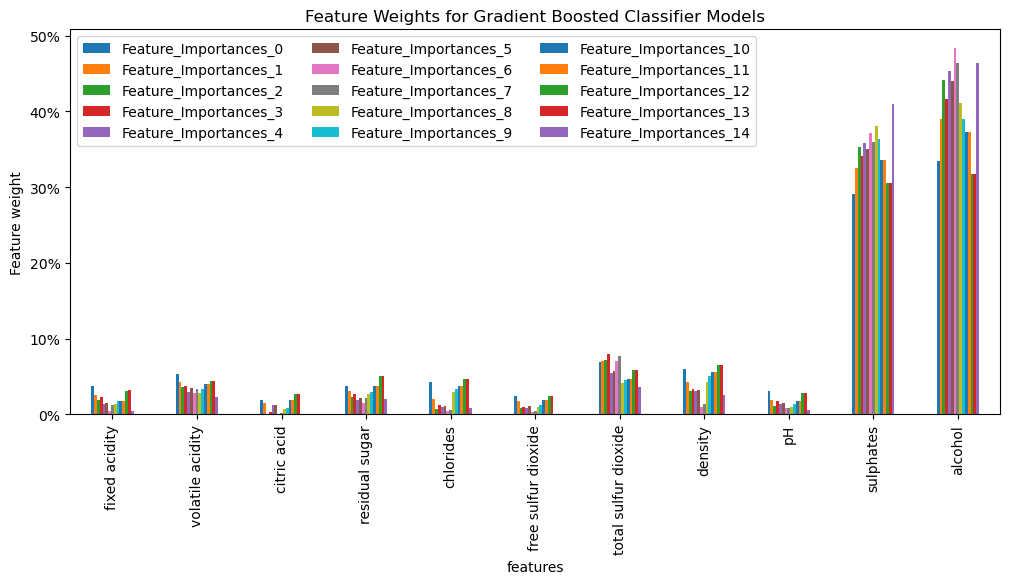

In [22]:
import matplotlib.ticker as mtick

features = list(X_val[:0])
# Create a bar chart
fig, ax = plt.subplots(figsize=(12,5))
feature_weight.plot.bar(ax=ax)

# Set x-axis labels using the index (which is now 'features' column)
ax.set_xticks(range(len(feature_weight.index)))
ax.set_xticklabels(features, rotation=90)  # Rotate labels for readability

# Format y-axis labels as percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

# Set labels and title
plt.ylabel('Feature weight')
plt.title('Feature Weights for Gradient Boosted Classifier Models')
ax.legend(loc='upper left', ncol=3)

# Show the plot
plt.show()

In [9]:
## Archive

# Create an empty dictionary to store the results
results_dict = {}

# Assuming dataset is your DataFrame
dataset = st_skf_df

for index, row in dataset.iterrows():
    feature_weights_df = pd.DataFrame()
    
    params = row
    model = GradientBoostingClassifier(
        n_estimators = int(params['estimators']),
        learning_rate = params['learning_rate'],
        max_depth = int(params['max_depth']),
        verbose = 1
    )

    # Fit the model
    model.fit(X_train_orig, y_train_orig)

    # Make predictions
    y_pred = model.predict(X_val_orig)

    # Get feature importances for this iteration
    feature_importances = model.feature_importances_
    
    # Create a new entry in the dictionary for this iteration
    results_dict[f'Iteration_{index + 1}'] = {
        'params': params,
        'feature_importances': list(feature_importances)
    }




      Iter       Train Loss   Remaining Time 
         1           1.2219            4.48s
         2           1.2142            4.13s
         3           1.2076            4.06s
         4           1.2014            3.92s
         5           1.1957            3.84s
         6           1.1903            3.82s
         7           1.1851            3.81s
         8           1.1800            3.75s
         9           1.1752            3.70s
        10           1.1704            3.65s
        20           1.1295            3.47s
        30           1.0975            3.25s
        40           1.0699            3.05s
        50           1.0456            2.87s
        60           1.0246            2.67s
        70           1.0063            2.50s
        80           0.9897            2.32s
        90           0.9748            2.13s
       100           0.9613            1.94s
       200           0.8684            0.00s
      Iter       Train Loss   Remaining Time 
        

In [20]:
import pprint as pp
pp.pprint(results_dict)

Text(0.5, 1.0, 'Bar Chart Title')

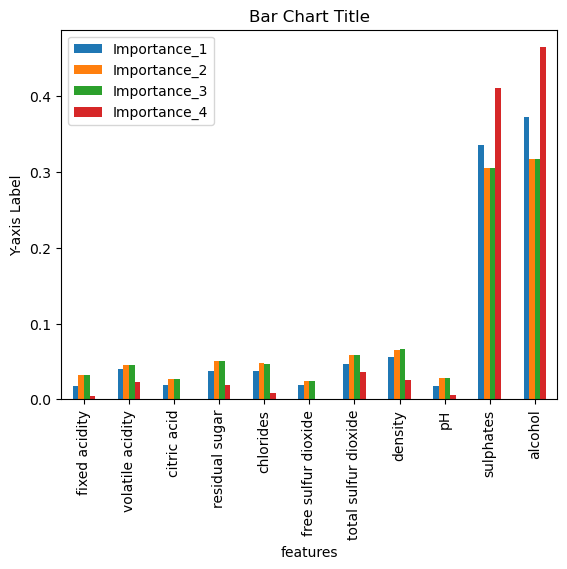

In [22]:
weights

In [ ]:
# Create a dictionary of DataFrames, one for each unique "stratification" value
model_comparo_dfs = {}
for stratification, group in model_param_comparo.groupby("stratification"):
    model_comparo_dfs[stratification] = group

# Access individual DataFrames using the stratification values
none_df = model_comparo_dfs["none"].reset_index(drop = True)
skf_df = model_comparo_dfs["skf"].reset_index(drop = True)
stratify_df = model_comparo_dfs["stratify"].reset_index(drop = True)
st_skf_df = model_comparo_dfs["st_skf"].reset_index(drop = True)

In [ ]:

for index, row in dataset.iterrows():
    params = row
    model = GradientBoostingClassifier(
        n_estimators = int(params['estimators']),
        learning_rate = params['learning_rate'],
        max_depth = int(params['max_depth']),
        verbose = 1
    )
    kappa = params['kappa']
    stratification = params['stratification']
    
    # Fit the model
    model.fit(X_train_orig, y_train_orig)

    # Make predictions
    y_pred = model.predict(X_val_orig)

    # Calculate accuracy (or any other desired metric)
    accuracy = accuracy_score(y_val_orig, y_pred)

    # Get feature importances for this iteration
    feature_importances = model.feature_importances_
    
    # Create a new column for this iteration's feature importances
    features_df[f'{stratification}, kappa: {kappa:.4f}'] = feature_importances